In [282]:
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import urllib.parse as urlparse
import requests
from matplotlib import rc
rc('font', family = "Arial Unicode MS")
# from urllib3 import request, urlopen
import urllib.request

### 데이터 로드

In [283]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

### 공휴일 데이터 받기

In [284]:
# 토, 일을 제외한 국경일 및 공휴일 추가
url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService"
operation = "getRestDeInfo"
mykey = 'ac%2FSOW4KzOFKdu0z01iEVWGZd4TBl1MyiR04%2FfYmADthCjJBEyL73pewbapUk94Gm1%2FqtzMCban3C%2BpqU8c7ew%3D%3D'

date = []
datename = []
for year in range(2016, 2022):
    year = str(year)
    
    for month in range(1, 13):
        if month < 10:
            month = "0" + str(month)
        else:
            month = str(month)
            
        params = {'solYear' : year, 'solMonth' : month}
        rq_query = url +'/' + operation + '?' + urlparse.urlencode(params) + "&serviceKey=" + mykey    
        response = requests.get(rq_query) 
        dom = BeautifulSoup(response.content, "html.parser")
        
        items = dom.find_all("item")
        for item in items:
            date.append(item.locdate.string)
            datename.append(item.datename.string)

holiday_df= pd.DataFrame({"date": date, "datename": datename})

In [285]:
# 휴일 전날
holiday_df['date'] = holiday_df['date'].apply(lambda x : datetime.strptime(x,'%Y%m%d'))
holiday_df['date'] = holiday_df['date'].apply(lambda x : x - relativedelta(days=1))
holiday_df['date'] = holiday_df['date'].apply(lambda x : datetime.strftime(x, '%Y-%m-%d'))
holiday_df['datename'] = holiday_df['datename'].apply(lambda x : '휴일전날')
holiday_df.columns = ['일자', '휴일전날']

<AxesSubplot:xlabel='휴일전날', ylabel='석식계'>

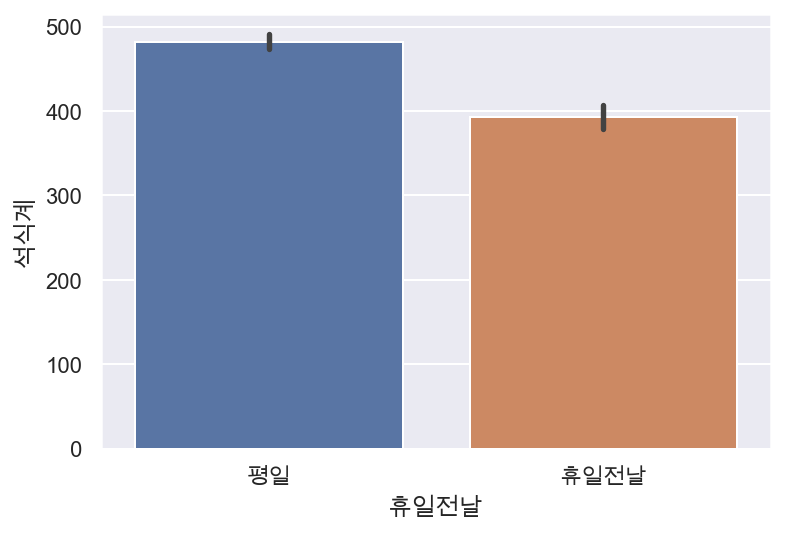

In [286]:
# merge
train_df = pd.merge(train, holiday_df, left_on='일자', right_on='일자', how='left')
before_friday = train_df[train_df['요일']=='금'].index
train_df['휴일전날'][before_friday] = '휴일전날'

train_df['휴일전날'] = train_df['휴일전날'].fillna('평일')
# 비교
sns.barplot(x=train_df['휴일전날'], y=train_df['석식계'], data=train_df)

In [287]:
train_df

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,휴일전날
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,평일
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,평일
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,평일
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,평일
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,휴일전날
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0,평일
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0,평일
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0,휴일전날
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0,평일


In [367]:
rain_df = pd.DataFrame()
for i in range(2016, 2022):
    tmp = pd.read_csv(f'./weather_data/{i}.csv', encoding='euc-kr')
    rain_df = rain_df.append(tmp)

In [368]:
rain_df = rain_df[['일시', '강수량(mm)']].rename(columns={'강수량(mm)':'강수량'}).reset_index(drop=True)
rain_df['일시'] = rain_df['일시'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M'))
rain_df['일자'] = rain_df['일시'].apply(lambda x : datetime.strftime(x, '%Y-%m-%d'))
rain_df['시간'] = rain_df['일시'].apply(lambda x : datetime.strftime(x, '%H'))
rain_df['시간'] = rain_df['시간'].astype('int')
rain_df = rain_df[['일자', '시간', '강수량']]

In [371]:
len(rain_df)

3979

In [372]:
lunch_rain_df = rain_df[(rain_df['시간'] == 12) & (rain_df['강수량'] >= 5)].reset_index(drop=True)
dinner_rain_df = rain_df[(rain_df['시간'] == 18) & (rain_df['강수량'] >= 5)].reset_index(drop=True)

In [373]:
lunch_rain_df

,일자,시간,강수량
0,2016-02-12,12,9.4
1,2016-05-24,12,8.7
2,2016-06-24,12,10.8
3,2016-09-02,12,5.7
4,2016-09-17,12,10.2
5,2016-09-30,12,9.0
6,2017-02-22,12,6.7
7,2017-08-22,12,6.9
8,2017-12-24,12,11.1
9,2018-01-16,12,5.4


In [374]:
dinner_rain_df

,일자,시간,강수량
0,2016-02-12,18,20.4
1,2016-03-04,18,20.3
2,2016-07-01,18,6.8
3,2016-11-18,18,5.1
4,2017-07-25,18,12.3
5,2017-07-31,18,21.0
6,2018-02-28,18,13.2
7,2018-11-08,18,6.5
8,2019-04-29,18,6.2
9,2019-06-26,18,6.8
